# Plot Summary Ancient Sardinians
Plot Summary Statistic per ancient Sardinian.
Important: Has Function to save the Summary .csv that is also needed in Violin Plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
from scipy import stats

socket_name = socket.gethostname()
print(socket_name)

if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine

elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster

else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

########## Some key Parameters
meta_path = "./Data/Marcus2019_1240k/meta_rev_final.csv"
#meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"  ### Important: Meta with unique IDs!
meta_df = pd.read_csv(meta_path)  # Load the Meta File

anc_sardind= 85
anc_ind =  1087

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Functions for loading the ROH Data

In [60]:
def get_ancient_sardinians(meta_path, min_cov=0.5, min_ind=0, max_ind=0):
    """Return a Pandas Dataframe of Summary Data for the ancient Sardinians"""
    meta_df = pd.read_csv(meta_path)  # Load the Meta File
    as_df = meta_df[min_ind:max_ind]  ### Change this here
    as_df = as_df[(as_df["mean_cov"]>=min_cov) & (as_df["include_alt"] > 0)]  # High Coverage Indivduals (Included)
    return as_df

def get_modern_iids(meta_path, pop_list, mod_ind, max_n=20):
    """Get IIDs of Modern individuals.
    pop_list: List of Populations of Meta found at meta_path
    mod_ind: Index where modern Individuals start.
    max_n: How Many individuals to do per population"""
    meta_df = pd.read_csv(meta_path)
    mod_df = meta_df[mod_ind:]
    
    iids = [] # Will be the IID List
    for p in pop_list:
        new_iids = mod_df.loc[mod_df["clst"]==p, "iid"].values
        iids += list(new_iids)[:max_n]  # Load max_n individuals
    print(f"Loaded {len(iids)} Individuals")
    return iids
    
def load_rohs(iid, path_folder = "./Empirical/1240k/", prefix_out="", output= True):
    """Load the ROH Dataframe for Individual iid"""
    if output==True:
        print(f"Doing Indivdiual {iid}")
    roh_dfs = []
    
    for ch in np.arange(1,23):
        path = path_folder + str(iid) + "/chr" + str(ch) + "/" + prefix_out + "roh.csv"
        
        if not os.path.exists(path):
            raise RuntimeWarning(f"Path {path} not found!!")
            continue # Skip Reading if not there
        roh = pd.read_csv(path)
        roh_dfs.append(roh)
    
    if len(roh_dfs)==0:
        raise RuntimeError(f"No Data for Individual {iid}")
    df_roh = pd.concat(roh_dfs)  
    return df_roh

def post_process_roh_df(df, min_cm=4, snp_cm=60, output=True):
    """Post Process ROH Dataframe. Filter to rows that are okay.
    min_cm: Minimum Length in CentiMorgan
    snp_cm: How many SNPs per CentiMorgan"""
    densities = df["length"] / (df["lengthM"] * 100)
    densities_ok = (densities > snp_cm)
    
    df["SNP_Dens"] = densities
    
    # Filter for SNP Density:
    df = df[densities_ok]
    
    # Filter for Length:
    length_okay = (df["lengthM"] * 100) > min_cm
    
    if output==True:
        print(f"Min SNPs per cM> {snp_cm}: {np.sum(densities_ok)}/{len(densities_ok)}")
        print(f"> {min_cm} cM: {np.sum(length_okay)}/{len(length_okay)}")
    
    df = df[length_okay]
    return df

def individual_roh_statistic(df, output=True):
    """Gives out Summary statistic of ROH df"""
    if len(df)==0:   # If no ROH Block found
        max_roh, sum_roh, n_roh = 0, 0, 0
    else:
        max_roh = np.max(df["lengthM"])
        sum_roh = np.sum(df["lengthM"])
        n_roh = len(df["lengthM"])
     
    if output==True:
        print(f"Max. ROH: {max_roh * 100:.3f}")
        print(f"Sum. ROH: {sum_roh * 100:.3f}")
        print(f"Nr. ROH: {n_roh}")   
    return max_roh, sum_roh, n_roh

### Prepare the Data:

def create_ancsard_df(iids, min_cm=4, snp_cm=100, prefix_out="", path_folder="./Empirical/1240k/", 
                      output=False, savepath = "./Empirical/1240k/ancsards_roh_summary.csv"):
    """Create the Ancient Sardinian Summary Dataframe
    iids: List of individuals to load
    path_folder: Folder where to Load Summaries from
    savepath: If given, where to save the summary csv to"""
    n = len(iids)

    # Default Values: Zero ROH
    max_roh = np.zeros(n, dtype="float")
    sum_roh = np.zeros(n, dtype="float")
    n_roh = np.zeros(n, dtype="int")

    for i, iid in  enumerate(iids):
        df_roh = load_rohs(iid, prefix_out=prefix_out, path_folder=path_folder, output=output)
        df_roh = post_process_roh_df(df_roh, output=output, snp_cm=snp_cm, min_cm=min_cm)  ### Do the Postprocessing
        max_roh[i], sum_roh[i], n_roh[i] = individual_roh_statistic(df_roh, output=output)

    ### Create the Dataframe:
    d = {"iid": iids, "max_roh": max_roh*100, "sum_roh" : sum_roh*100, "n_roh" : n_roh}
    df1 = pd.DataFrame(d).sort_values(by="sum_roh", ascending=False)  # Sort output
    
    if len(savepath) > 0:
        df1.to_csv(savepath, sep=",", index=False)
        print(f"Saved to: {savepath}")
        
    return df1

#### Code For the Figure
def plot_sard_inbreed(df1, savepath = "", min_cm=4, reference_pts=False, title="Consanguinity in Ancients", annotate=True):
    """Make Figure of Sharing Longer than Threshold (Total Length vrs Nr).
    df1: Pandas DataFrame with ROH Data"""
    fsl = 18
    fs_dots = 8
    
    x,y = df1["sum_roh"].values, df1["n_roh"].values

    plt.figure(figsize=(6,6))
    plt.scatter(x,y , c="royalblue", edgecolors="k", s=50, zorder=0, alpha=0.6)
    plt.xlabel(f"Sum ROH > {min_cm} cM", fontsize=fsl)
    plt.ylabel(f"Count ROH > {min_cm} cM", fontsize=fsl)
    
    plt.tick_params(axis='both', which='major', labelsize=fsl*0.8)
    
    plt.title(title, fontsize=fsl)
    
    if annotate==True:
        for i, txt in enumerate(df1["iid"]):
            plt.annotate(txt, (x[i]-15, y[i]-1.5), fontsize=fs_dots, zorder=1)
        
    if reference_pts == True:
        labels = ["Third Cousin", "Second Cousin", "First Cousin", "Nephew-Aunt"]
        tot_ROH = [13.05, 53.17, 215.87, 433.76]
        n_ROH =[1.00, 3.49, 11.55, 20.33]
        colors = ["yellow", "orange", "red", "darkred"]
        for i in range(len(labels)):
            plt.scatter(tot_ROH[i], n_ROH[i], c=colors[i], s=150, marker="h", label=labels[i], zorder=2, edgecolors="k")
        leg = plt.legend(loc = "upper left", fontsize=fsl*0.6)
        leg.set_title("Parents being...", prop = {'size':fsl})
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()

### Load All Ancients

In [39]:
%%time
meta_df = get_ancient_sardinians(meta_path, min_cov=0.5, min_ind=0, max_ind=anc_ind)
iids = meta_df["iid"]
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/", output = False)   #I2105/chr1/e01

Saved to: ./Empirical/1240k/ancsards_roh_summary.csv
CPU times: user 59.5 s, sys: 3.93 s, total: 1min 3s
Wall time: 4min 43s


In [41]:
### Loading from Summary .csv
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"
df_load = pd.read_csv(path_rohs_info)
print(f"Loaded {len(df_load)} Individuals")

Loaded 557 Individuals


# Do Modern Populations

In [7]:
%%time
pop_list = ["Czech", "Bergamo", "Basque", 'Spanish', 'French', 'Croatian', "Cag", "Ogl", "Olb", "Car", "Cam", "Ori", "Sas", "Nuo"]
#pop_list = ["Ogl"]

iids = get_modern_iids("./Data/Marcus2019_1240k/meta_rev_unique_ids.csv", pop_list, mod_ind=1098, max_n=20)

Loaded 250 Individuals
CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 32.1 ms


In [43]:
%%time
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/HO/", 
                        output = False, savepath = "")   # Load, process and save as .csv ./Empirical/1240k/modern_roh_summary.csv

CPU times: user 2.25 s, sys: 119 ms, total: 2.36 s
Wall time: 4.57 s


### Repeat for All Modern Populations

In [63]:
#pop_list = ["Basque", 'Spanish', 'French', 'Croatian', "Cag", "Ogl", "Olb"]
#pop_list = ["Car", "Cam", "Ori", "Sas", "Nuo", "Czech", "Bergamo"]
#pop_list = ["Italian_South", "Sicilian", "Icelandic", "Norwegian", "English", "Greek"]
pop_list = ["Basque", "Bergamo", 'Spanish', 'French', 'Croatian', 'Albanian',  'Ashkenazi_Jew', 'Belarusian', 'Bulgarian', 'Estonian', 'Finnish', 'French_South', 'Hungarian', 
            'Lithuanian', 'Maltese', 'Russian', 'Scottish', 'Spanish_North', 'Turkish', 'Tuscan', 'Ukrainian',
           "Italian_South", "Sicilian", "Icelandic", "Norwegian", "English", "Greek"]

iids = get_modern_iids("./Data/Marcus2019_1240k/meta_rev_unique_ids.csv", pop_list, mod_ind=1098, max_n=20)

Loaded 308 Individuals


In [64]:
%%time
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/HO/", 
                        output = False, savepath = "./Empirical/1240k/HO_roh_summary.csv")  # Load, process and save as .csv ./Empirical/1240k/modern_roh_summary.csv

Saved to: ./Empirical/1240k/HO_roh_summary.csv
CPU times: user 37.7 s, sys: 2.02 s, total: 39.8 s
Wall time: 1min 33s


# Load saved Data
Speeds up as no recalling needs to be done

In [3]:
#path_rohs_info = "./Empirical/1240k/modern_roh_summary.csv"      # Present-day ROH Data
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"     # Ancient ROH Data
df_load = pd.read_csv(path_rohs_info)

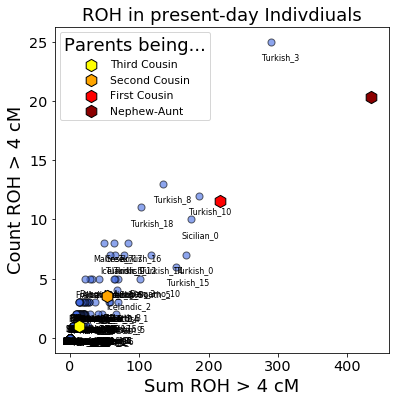

In [69]:
savepath="./figures_test/modern_ogl_cumroh.pdf"
savepath = ""
# Enter df_load if necessary
plot_sard_inbreed(df1, savepath=savepath, reference_pts=True, title= "ROH in present-day Indivdiuals", annotate=True)

In [77]:
df1[df1["iid"].str.startswith("Sicilian")]

,iid,max_roh,sum_roh,n_roh
244,Sicilian_0,49.771804,175.371593,10
250,Sicilian_6,16.575700,21.151299,2
249,Sicilian_5,18.740600,18.740600,1
252,Sicilian_8,6.097800,6.097800,1
251,Sicilian_7,4.284597,4.284597,1
245,Sicilian_1,0.000000,0.000000,0
248,Sicilian_4,0.000000,0.000000,0
247,Sicilian_3,0.000000,0.000000,0
253,Sicilian_9,0.000000,0.000000,0
254,Sicilian_10,0.000000,0.000000,0


# Plot ROH against vrs Variables
Stand Alone, loads the summary .csv saved above

In [10]:
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"
df1 = pd.read_csv(path_rohs_info)
print(f"Loaded {len(df1)} Individuals")

full_df = pd.merge(df1, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")

Loaded 557 Individuals


In [97]:
def plot_age_roh(full_df, pop_groups=[], pop_labels=[], pop_colors = [],
                 savepath = "./Empirical/AncSards/roh_summary_age.pdf", ylim=[], xlim=[], fsl=18, s=50):
    """Plot ROH against Age.
    pop_groups: List of List of populations to plot
    pop_labels: List of Labels for the Populations
    pop_colors: List of Colors for the Populations to plot"""
    assert(len(pop_groups)==len(pop_labels)==len(pop_colors))
    
    x, y = full_df["age"] - 1950, full_df["sum_roh"]
    
    _, _, r2, p_value, _ = stats.linregress(x, y)
    print(p_value)
 
    ### Hack in the colors:
    colors = np.array(["royalblue" for _ in range(len(full_df))])

    plt.figure(figsize=(10,6))
    ax = plt.gca()
    
    plt.scatter(x, y, s=s, edgecolors="k", c="gray")  # Plot the Background
    
    for i, pops in enumerate(pop_groups):
        inds = full_df["clst"].isin(pops)

        plt.scatter(x[inds], y[inds], c=pop_colors[i], s=s, 
                    edgecolors="k", label = pop_labels[i])
        
    plt.xlabel("Age BCE [years]", fontsize=fsl)
    plt.ylabel("Sum ROH >4 cM [cM]", fontsize=fsl)
    ax.invert_xaxis()
    
    plt.text(0.8, 0.8, f"r: {r2:.3f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    plt.text(0.8, 0.75, f"p: {p_value:.6f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    
    plt.legend(loc="upper left", fontsize=fsl)
    
    if len(ylim)>0:
        plt.ylim(ylim)
        
    if len(xlim)>0:
        plt.xlim(xlim)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()
    
    
def plot_cov_roh(full_df, savepath = "./Empirical/AncSards/roh_summary_cov.pdf", ylim=[], xlim=[], fsl=18, s=40):
    """Plot ROH against Age"""
    x, y = full_df["mean_cov"], full_df["sum_roh"]
    age = full_df["age"]
    
    _, _, r2, p_value, _ = stats.linregress(x, y)

    
    ### Do Linear Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(full_df["mean_cov"], full_df["sum_roh"])
    slope, intercept, r_value, p_value, std_err

    plt.figure(figsize=(12,6))
    ax = plt.gca()
    plt.scatter(x, y, c=age, s=s, edgecolors="k", cmap="viridis_r") # royalblue
    plt.xlabel("Avg. 1240k Depth", fontsize=fsl)
    plt.ylabel("Sum ROH >4 cM", fontsize=fsl)
    #ax.invert_xaxis()
    
    plt.text(0.8, 0.8, f"r: {r2:.3f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    plt.text(0.8, 0.75, f"p: {p_value:.4f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    
    cb = plt.colorbar()
    #cb.ax.set_yticklabels(['0','1','2','>3'])
    cb.set_label('Age [y BP]', rotation=270, fontsize=fsl, labelpad=20)

    if len(ylim)>0:
        plt.ylim(ylim)
        
    if len(xlim)>0:
        plt.xlim(xlim)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
        
    plt.show()

3.612293385008778e-05


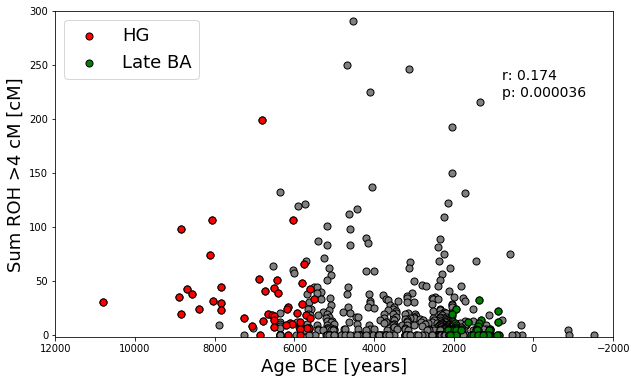

In [98]:
hg_pops = ["WHG-HG", 'EHG-HG', 'Ukraine-HG', 'SHG-HG', 'Iron_Gates-HG', "Natufian-HG"]
ba_pops = ["CE-LBA", "GB-LBA"]

pop_groups=[hg_pops, ba_pops]
pop_labels=["HG", "Late BA"] 
pop_colors = ["red", "green"]

plot_age_roh(full_df, pop_groups=pop_groups, pop_labels=pop_labels, pop_colors=pop_colors, 
             savepath="", ylim=[-2,300], xlim=[12000, -2000])

### Zoom in a bit:

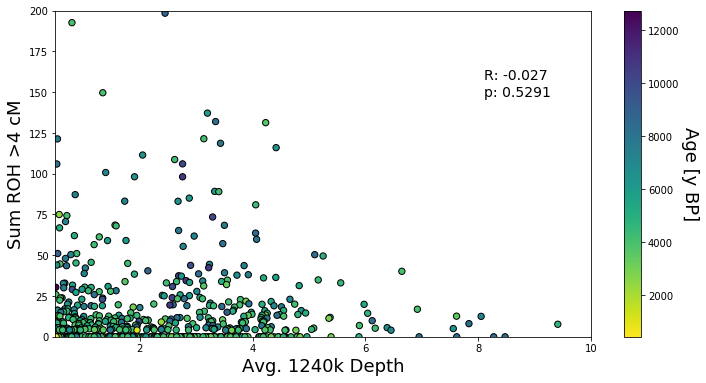

In [61]:
plot_cov_roh(full_df, savepath="", ylim=[0,200], xlim=[0.5, 10], s=40)

In [81]:
full_df.sort_values(by="age", ascending=False)

,iid,max_roh,sum_roh,n_roh,n_cov_snp,age,clst,mean_cov
98,I1072,6.796003,30.383813,6,407143,12750.0,Natufian-HG,0.507805
81,I5235,12.372601,34.461196,5,808973,10834.5,Iron_Gates-HG,2.818632
143,I5240,5.263698,19.468797,4,794954,10805.0,Iron_Gates-HG,2.532507
23,I5244,19.836301,98.115098,11,795782,10785.0,Iron_Gates-HG,2.756651
65,I1819,12.962799,42.378800,6,783205,10643.0,Ukraine-HG,3.219887
75,I5242,6.385804,37.424498,7,823870,10530.0,Iron_Gates-HG,2.687032
116,I5239,8.482599,23.999601,4,795841,10332.5,Iron_Gates-HG,2.573165
33,I1763,11.227399,73.460896,11,801263,10073.5,Ukraine-HG,3.289391
19,I5236,40.261596,106.036882,7,809579,10007.5,Iron_Gates-HG,2.756767
96,I5238,11.994399,30.826182,4,810162,9992.5,Iron_Gates-HG,2.577877


# Area 51

In [ ]:
from scipy import stats
x = np.random.random(10)
y = np.random.random(10)
slope, intercept, r_value, p_value, std_err = stats.linregress(full_df["mean_cov"], full_df["sum_roh"])
slope, intercept, r_value, p_value, std_err

In [10]:
### Do a single individual
df = load_rohs(iid="MA89")
df = post_process_roh_df(df, min_cm=3, snp_cm=100, output=True)
individual_roh_statistic(df, output=True)

Min SNPs per cM> 100: 96/101
> 3 cM: 31/96
Max. ROH: 40.237
Sum. ROH: 394.451
Nr. ROH: 31


(0.4023729600000001, 3.9445078799999997, 31)

In [102]:
meta_df[400:420]

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp_read,full_iid,n_cov_snp
400,I6585,Beaker Iberia,40.220000,-3.760000,NaN,NaN,4189.5,Olalde et al. 2018,Iberia,Bk,1,Iberia-BA,0.008332,0.0,9454.0,I6585,9454
401,I7196,Czech_EBA,50.050415,14.366727,NaN,NaN,3900.0,Olalde et al. 2018,Czech,EBA,1,CE-LBA,2.252734,1.0,693680.0,I7196,693680
402,I6471,Beaker Iberia,40.490330,-3.373888,NaN,NaN,4200.0,Olalde et al. 2018,Iberia,Bk,1,Iberia-BA,0.031134,0.0,34803.0,I6471,34803
403,I1382,Beaker Central Europe,49.153000,6.102000,NaN,NaN,4234.5,Olalde et al. 2018,Central Europe,Bk,1,CE-EBA,1.188095,1.0,578156.0,I1382,578156
404,I7205,Beaker Central Europe,50.410265,14.074597,NaN,NaN,4300.0,Olalde et al. 2018,Central Europe,Bk,1,CE-EBA,3.291437,1.0,743492.0,I7205,743492
405,I2639,England_MBA,51.160000,-1.770000,NaN,NaN,3465.0,Olalde et al. 2018,England,MBA,1,GB-LBA,1.904921,0.0,568737.0,I2639,568737
406,I3874,Beaker Southern France,44.476000,6.369000,NaN,NaN,4067.5,Olalde et al. 2018,Southern France,Bk,1,CE-LBA,1.611416,1.0,641533.0,I3874,641533
407,I7568,England_MBA,52.340000,0.030000,NaN,NaN,3400.0,Olalde et al. 2018,England,MBA,1,GB-LBA,3.564796,1.0,758247.0,I7568,758247
408,I5523,Beaker Central Europe,48.663000,12.707000,NaN,NaN,4200.0,Olalde et al. 2018,Central Europe,Bk,1,CE-EBA,0.705296,0.0,518092.0,I5523,518092
409,I6778,Beaker Britain,51.147052,-1.812529,NaN,NaN,4150.0,Olalde et al. 2018,Britain,Bk,1,GB-EBA,1.223008,0.0,569227.0,I6778,569227
